In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('font', family='serif', size=11)
mpl.rc('savefig', bbox='tight')

import dtw
import worg

make_fname_safe = lambda s: s.lower().replace(' ', '-')

/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.enrichment is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
T = 50
seed = 424242
verbose = True
f = 90 * (1.01**np.arange(T))  # 1% growth
g0 = np.zeros(T, dtype='f8')    # zero production
N = np.asarray(np.ceil(4*(1.01)**np.arange(T)), dtype=int)

DTW
======

In [3]:
def display_dwt(dist, cost, path, xname, yname, offset=2016, vmax=None):
    fig = plt.figure(figsize=(8, 6))
    extent = (offset, offset+cost.shape[1], offset, offset+cost.shape[0])
    plt.imshow(cost[::-1], cmap='viridis', extent=extent, vmin=0.0, vmax=vmax)
    u = offset + np.concatenate([path, np.array([[cost.shape[1]], [cost.shape[0]]])], axis=1)
    plt.plot(u[1], u[0], 'w-')
    plt.axis(extent)
    cb = plt.colorbar()
    cb.set_label('Cost [GWe]', rotation=-90, va='bottom')
    plt.xlabel('time [year]')
    plt.ylabel('time [year]')
    fname = 'cost-{0}-to-{1}'.format(make_fname_safe(xname), make_fname_safe(yname))
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.eps')
    print('Warping between {0} and {1}:'.format(xname, yname))
    print('  Distance is ', dist)

Warping between Demand and Production:
  Distance is  0.755990232857


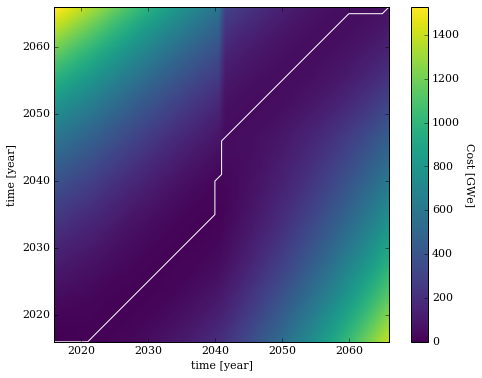

In [4]:
p = np.empty(T, dtype='f8')
p[:T//2] = f[:T//2] * 0.95
p[T//2:] = f[T//2:] * 1.05
dist, cost, path = dtw.dtw(f[:,np.newaxis], p[:,np.newaxis])
display_dwt(dist, cost, path, 'Demand', 'Production')

GP
=======

In [5]:
def model_plot(t, y, yerr, tpred, mu, std, title=None, ymax=None):
    fig = plt.figure(figsize=(8, 8))
    #plt.errorbar(t, y, yerr, fmt='r.', label='traing data')
    plt.plot(t, y, 'r.', label='traing data')
    plt.plot(tpred, mu, 'k-', label='model')
    plt.fill_between(tpred, mu - 2*std, mu + 2*std, color='gray')
    ax = plt.axis()
    plt.axis([tpred[0], tpred[-1], 0.0, ymax or ax[3]])
    plt.legend(loc=0)
    plt.xlabel('time [year]')
    plt.ylabel('Power Production [GWe]')
    if title:
        plt.title(title)
    fbase = 'gwe-model-' + (title or '').lower().replace(' ', '-')
    plt.savefig(fbase + '.eps')
    plt.savefig(fbase + '.png')

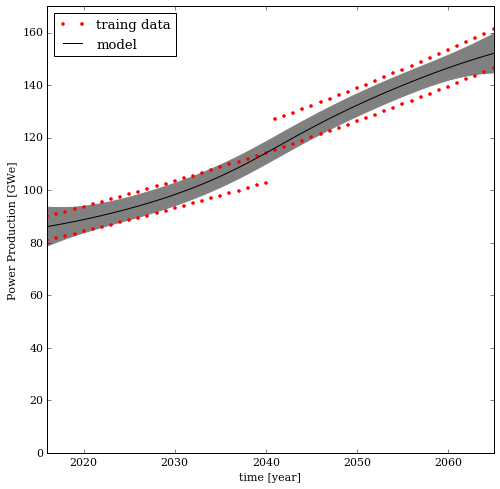

In [6]:
tol = 1e-1
q = np.empty(T, dtype='f8')
q[:T//2] = f[:T//2] * 0.9
q[T//2:] = f[T//2:] * 1.1
gp, x, y = worg.gp_gwe([N, N], [f, q], T, tol, N)
mu, cov = gp.predict(y, x[:T])
std = np.sqrt(np.diag(cov))
model_plot(x[:,0]+2016, y, 0.0, x[:T,0] + 2016, mu, std)

Optimizations
========

In [14]:
def run_percent_growth(rate, f0=90.0, N0=4, T=T, seed=seed, verbose=verbose, **kwargs):
    r = 1.0 + (rate/100.0)
    tgrid = np.arange(T)
    f = f0 * (r**tgrid)
    N = np.asarray(np.ceil(N0*(r**tgrid)), dtype=int)
    state = worg.optimize(f, N, seed=seed, verbose=verbose, **kwargs)
    return state

def covergence_plot(states, linestyles, labels):
    for state, ls, label in zip(states, linestyles, labels):
        x = np.arange(1, state['s'] + 1)
        D_s = state['D_s']
        y = np.fromiter((min(D_s[:i]) for i in x), dtype='f8', count=len(x))
        plt.semilogy(x, y, linestyle=ls, color='gray', label=label)
        smask = np.fromiter((w == 'stochastic' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(smask):
            plt.semilogy(x[smask], y[smask], linestyle='None', marker='$S$')
        imask = np.fromiter((w == 'inner-prod' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(imask):
            plt.semilogy(x[imask], y[imask], linestyle='None', marker='$I$')
        amask = np.fromiter((w == 'all' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(amask):
            plt.semilogy(x[amask], y[amask], linestyle='None', marker='$A$')
    plt.grid()
    plt.legend(loc=0)
    plt.xlabel('Simulation $s$')
    plt.ylabel('Minimum Distance, $d(f, g_s)$')

In [8]:
%time state1all = run_percent_growth(1, MAX_S=20)

Simulation 3
------------
SimId 9b819167-c864-419b-9dee-741985c87ed5
hyperparameters: [ 8.44155389  5.41756185]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 11.202484607696533 sec
Simulation time: 0.0 min 6.9000208377838135 sec
D_s: 6.570023932232067
D: [6.5700239322320666, 14.802403115793279]

Simulation 4
------------
SimId 6b38c884-be36-46e8-a9e6-6629a855f276
hyperparameters: [ 7.8516871  4.6362031]
Estimate method is 'all'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 11.132542610168457 sec
Simulation time: 0.0 min 7.460326671600342 sec
D_s: 3.430372021094819
D: [3.430372021094819, 6.5700239322320666]

Simulation 5
------------
SimId 6d662b29-182c-498d-ac6f-99eb360dc449
hyperparameters: [ 6.95455644  4.15281822]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 8.787530899047852 sec
Simulation time: 0.0 min 8.147444009780884 sec
D_s: 3.5944212704894225
D: [3.430372021094819, 3.5944212704894225]



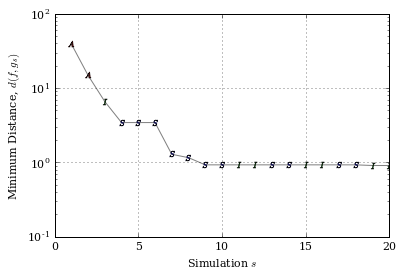

In [9]:
covergence_plot([state1all], ['-'], ['all'])

In [10]:
%time state1sto = run_percent_growth(1, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId c81a787b-208b-420f-a7cc-a38e4f04ad32
hyperparameters: [ 8.44155389  5.41756185]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 8.338396072387695 sec
Simulation time: 0.0 min 7.606963396072388 sec
D_s: 3.473439561746035
D: [3.473439561746035, 14.802403115793279]

Simulation 4
------------
SimId 6dd3c060-2bb8-4749-a79e-b33743d67ee8
hyperparameters: [ 7.6581606   4.55373561]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 8.540717124938965 sec
Simulation time: 0.0 min 8.002076148986816 sec
D_s: 0.9452935300317574
D: [0.94529353003175742, 3.473439561746035]

Simulation 5
------------
SimId 2c476384-7714-4830-9649-82a34f57466c
hyperparameters: [ 6.81649512  4.1517704 ]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 8.61294937133789 sec
Simulation time: 0.0 min 8.695771932601929 sec
D_s: 1.2048628798885026
D: [0.94529353003175742, 1.2048

In [11]:
%time state1inn = run_percent_growth(1, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId c6743cd7-59c1-4625-8b77-ad368d340711
hyperparameters: [ 8.44155389  5.41756185]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 3.235478162765503 sec
Simulation time: 0.0 min 7.362612962722778 sec
D_s: 6.570023932232067
D: [6.5700239322320666, 14.802403115793279]

Simulation 4
------------
SimId d0c1415c-6584-4d9b-9ef4-2f5f84ef40a3
hyperparameters: [ 7.8516871  4.6362031]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 3.5818300247192383 sec
Simulation time: 0.0 min 9.73605489730835 sec
D_s: 6.937509162046698
D: [6.5700239322320666, 6.9375091620466982]

Simulation 5
------------
SimId a6bfcdb9-01e4-4474-ba49-2301f21d6b7f
hyperparameters: [ 7.31105279  4.41047611]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 3.427809000015259 sec
Simulation time: 0.0 min 10.788515090942383 sec
D_s: 8.436922012154572
D: [6.5700239322320666, 6.937509

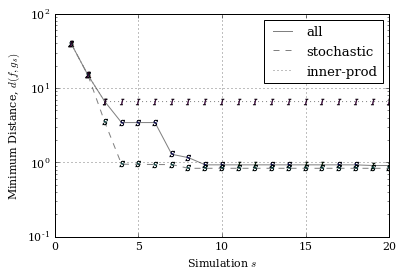

In [17]:
covergence_plot([state1all, state1sto, state1inn], ['-', '--', 'dotted'], 
                ['all', 'stochastic', 'inner-prod'])

In [18]:
%time state0sto = run_percent_growth(0, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId 3bb912df-46d3-462f-a0f8-dbf5e786ac98
hyperparameters: [ 7.83341714  5.4057358 ]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 6.567006826400757 sec
Simulation time: 0.0 min 7.490050792694092 sec
D_s: 15.438333333332489
D: [15.438333333332489, 21.284999999999499]

Simulation 4
------------
SimId 4da936c8-7e1f-4edd-b45d-0918e73df886
hyperparameters: [ 6.23822013  3.87961885]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 6.601877927780151 sec
Simulation time: 0.0 min 7.61642050743103 sec
D_s: 4.359999999999391
D: [4.359999999999391, 15.438333333332489]

Simulation 5
------------
SimId 1b4e42c2-a79b-422b-807b-b1beec68aa71
hyperparameters: [ 5.79799764  3.68637691]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 6.47586464881897 sec
Simulation time: 0.0 min 7.7184739112854 sec
D_s: 2.0958333333334105
D: [2.0958333333334105, 4.35999999

In [19]:
%time state2sto = run_percent_growth(2, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId c89d3ceb-9bb3-4270-a693-3c28c87e4be9
hyperparameters: [ 8.92215213  5.44922166]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 10.231712818145752 sec
Simulation time: 0.0 min 9.128502607345581 sec
D_s: 2.6202479848698066
D: [2.6202479848698066, 6.6040820192166567]

Simulation 4
------------
SimId 21171760-95fe-490d-acec-74f6517e68dc
hyperparameters: [ 8.32312716  4.64423469]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 10.25078797340393 sec
Simulation time: 0.0 min 9.411796569824219 sec
D_s: 1.8041093301932833
D: [1.8041093301932833, 2.6202479848698066]

Simulation 5
------------
SimId f8a01b4d-5dbd-4cc3-bcdd-675d9aa75386
hyperparameters: [ 7.88824771  4.50156885]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 10.491726398468018 sec
Simulation time: 0.0 min 10.19625735282898 sec
D_s: 3.9972602918887925
D: [1.8041093301932833, 2.

In [20]:
%time state2all = run_percent_growth(2, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 38d0d0b2-d8dc-499a-8d13-d8153a57d12f
hyperparameters: [ 8.92215213  5.44922166]
Estimate method is 'all'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 14.646517276763916 sec
Simulation time: 0.0 min 9.159938335418701 sec
D_s: 2.6202479848698066
D: [2.6202479848698066, 6.6040820192166567]

Simulation 4
------------
SimId 12b8283a-9f23-4203-9978-bc6ff71e60cf
hyperparameters: [ 8.32312716  4.64423469]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 14.251596927642822 sec
Simulation time: 0.0 min 10.312356948852539 sec
D_s: 2.474010004927797
D: [2.4740100049277971, 2.6202479848698066]

Simulation 5
------------
SimId 1f5acfb1-9f28-4ba5-9eb5-44e2abec96aa
hyperparameters: [ 7.78839557  4.34833544]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 10.288766145706177 sec
Simulation time: 0.0 min 10.854229211807251 sec
D_s: 1.2983842237827958
D: [1.2983842237827958, 2.474010004927

In [21]:
%time state2inn = run_percent_growth(2, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId 616a98ab-61b2-4c4c-9f08-5ed3d203d602
hyperparameters: [ 8.92215213  5.44922166]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 4.388369560241699 sec
Simulation time: 0.0 min 8.433597326278687 sec
D_s: 4.303427295837437
D: [4.3034272958374373, 6.6040820192166567]

Simulation 4
------------
SimId 5fb4336a-5151-4de7-a9f7-7691dcd6982f
hyperparameters: [ 8.52616205  4.76425133]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 4.391035795211792 sec
Simulation time: 0.0 min 10.345962762832642 sec
D_s: 3.3527998955873732
D: [3.3527998955873732, 4.3034272958374373]

Simulation 5
------------
SimId 79aa0bbc-40c9-4161-8ba9-4e3c95639b28
hyperparameters: [ 8.35947076  4.71502271]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 4.270989418029785 sec
Simulation time: 0.0 min 11.565823316574097 sec
D_s: 3.977826469907656
D: [3.3527998955873732, 3.97

In [22]:
%time state0all = run_percent_growth(0, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 854e51ea-78a8-4518-abff-4b5312562a0a
hyperparameters: [ 7.83341714  5.4057358 ]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 8.524306774139404 sec
Simulation time: 0.0 min 5.887246370315552 sec
D_s: 8.437499999999794
D: [8.4374999999997939, 21.284999999999499]

Simulation 4
------------
SimId 4d1390e6-f37b-4c06-9914-f8d7866f5a8b
hyperparameters: [ 6.87790145  4.44872698]
Estimate method is 'all'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 8.46074366569519 sec
Simulation time: 0.0 min 6.1465349197387695 sec
D_s: 13.219166666666474
D: [8.4374999999997939, 13.219166666666474]

Simulation 5
------------
SimId f1b115a7-55a3-404d-865e-6a4fbe606dc4
hyperparameters: [ 5.22606539  3.51199562]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 6.267287492752075 sec
Simulation time: 0.0 min 7.418303489685059 sec
D_s: 4.075833333333252
D: [4.0758333333332519, 8.4374999999997939]


In [23]:
%time state0inn = run_percent_growth(0, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId 02f4b8d8-d75b-467d-a85d-13e7a80979e0
hyperparameters: [ 7.83341714  5.4057358 ]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 2.4461851119995117 sec
Simulation time: 0.0 min 5.946374416351318 sec
D_s: 8.437499999999794
D: [8.4374999999997939, 21.284999999999499]

Simulation 4
------------
SimId c8feb9b8-992d-433d-863d-1059f15ab670
hyperparameters: [ 6.87790145  4.44872698]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 2.3183071613311768 sec
Simulation time: 0.0 min 7.704135179519653 sec
D_s: 7.399166666666246
D: [7.3991666666662459, 8.4374999999997939]

Simulation 5
------------
SimId ce997969-3999-4de2-b5c7-d991ddc01b9e
hyperparameters: [ 5.78713189  3.72015686]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 2.223253011703491 sec
Simulation time: 0.0 min 7.264616012573242 sec
D_s: 8.718333333333199
D: [7.3991666666662459, 8.437